# CS 584 Assignment 2 -- MLP and Word Vectors

#### Name: Agamdeep S. Chopra

## In this assignment, you are required to follow the steps below:
1. Review the lecture slides.
2. Implement MLP.
3. Implement Word2Vec

*** Please read the code and comments very carefully and install these packages (NumPy, Pandas, sklearn, tqdm, spacy, and matplotlib) before you start ***

In [1]:
###############################################################
#                                                             #
#    Run this cell to make sure all packages are installed.   #
#                                                             #
###############################################################

!pip install numpy pandas scikit-learn tqdm matplotlib
!pip install -U spacy
!python -m spacy download en_core_web_sm

  Using cached preshed-3.0.5-cp38-cp38-win_amd64.whl (112 kB)
  Using cached wasabi-0.8.2-py3-none-any.whl (23 kB)
  Using cached murmurhash-1.0.5-cp38-cp38-win_amd64.whl (21 kB)
  Using cached blis-0.7.4-cp38-cp38-win_amd64.whl (6.5 MB)
  Using cached cymem-2.0.5-cp38-cp38-win_amd64.whl (36 kB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. MLP (30 points)
In this section, you are required to implement the MLP in the following steps.
1. Data Processing (Same as assignment 1, you could directly use your code in assignment 1.)
2. MLP
3. Evaluation

### 1.1 Data Processing

#### load data

In [1]:
import pandas as pd

# training data
train_df = pd.read_csv('./data/train.csv', header=None)
train_df.columns = ['label', 'title', 'text']

# test data
test_df = pd.read_csv('./data/test.csv', header=None)
test_df.columns = ['label', 'title', 'text']

####  Preprocessing

In [2]:
import re
import string

class Preprocesser(object):
    def __init__(self, punctuation=True, url=True, number=True):
        self.punctuation = punctuation
        self.url = url
        self.number = number
    
    def apply(self, text):
        if self.url:
            text = self._remove_url(text)
            
        if self.punctuation:
            text = self._remove_punctuation(text)
            
        if self.number:
            text = self._remove_number(text)
        
        text = re.sub(r'\s+', ' ', text)
            
        return text
    
        
    def _remove_punctuation(self, text):
        ''' Please fill this function to remove all the punctuations in the text
        '''
        return text.translate(str.maketrans('','', string.punctuation))
    
    def _remove_url(self, text):
        ''' Please fill this function to remove all the urls in the text
        '''
        return re.sub(r'http\S+','',text)
    
    def _remove_number(self, text):
        ''' Please fill this function to remove all the numbers in the text
        '''
        return text.translate(str.maketrans('','', string.digits))

#### Tokenization

In [3]:
import spacy
nlp = spacy.load('en_core_web_sm')

def tokenize(text):
    ''' Please fill this function to tokenize text.
            1. Tokenize the text.
            2. Remove stop words.
            3. Optional: lemmatize words accordingly.
    '''
    
    ### Start your code
    processer = Preprocesser()
    clean_text = processer.apply(text)
    tokens = clean_text.split()  
    ### End
    
    return tokens

#### Data Split

In [4]:
from sklearn.model_selection import train_test_split

text_train = train_df['text'].values.astype(str)
label_train = train_df['label'].values.astype(int) - 1 # -1 because labels start from 1

text_test = test_df['text'].values.astype(str)
label_test = test_df['label'].values.astype(int) - 1 # -1 because labels start from 1


text_train, text_valid, label_train, label_valid = train_test_split(text_train, label_train, test_size=0.2)


print('The size of training set:', text_train.shape[0])
print('The size of validation set:', text_valid.shape[0])
print('The size of testing set:', text_test.shape[0])

The size of training set: 96000
The size of validation set: 24000
The size of testing set: 7600


#### Feature Extraction

In [72]:
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm

class TfIdfExtractor(object):
    
    def __init__(self, vocab_size=None):
        self.vocab_size = vocab_size
        
        self.vocab = defaultdict(lambda: 0)
        self.word2idx = {}
        self.df = defaultdict(lambda: 0)
        self.num_doc = 0
        
        self.processer = Preprocesser()
        
        
    def fit(self, texts):
        ''' In this function, you are required to implement the fitting process.
                1. Construct the vocabulary (self.vocab).
                2. Construct the document frequency dictionary (self.df).
                3. Sort the vocabulary based on the frequence (self.vocab).
            Input:
                texts: a list of text (training set)
            Output:
                None
        '''

        self.num_doc = len(texts)
        
        for text in tqdm(texts, desc='fitting text'):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)
            
            ### Start your code (step 1 & 2)
            for i in tokens:
                self.vocab[i]
                self.df[i] += 1
            ### End
        
        ### Start your code (Step 3)
        self.vocab = dict(sorted(self.vocab.items(), key=lambda x: self.df[x[0]], reverse=True))
        #print(self.vocab)
        ### End
        
        if self.vocab_size is not None:
            self.vocab = {key: self.vocab[key] for key in list(self.vocab.keys())[:self.vocab_size]}
        
        self.word2idx = {key: idx for idx, key in enumerate(self.vocab.keys())}
        
        #print(self.vocab)
        #print(self.word2idx)
        
    def transform(self, texts):
        ''' In this function, you need to encode the input text into TF-IDF vector.
            Input:
                texts: a list of text.
            Ouput:
                a N-d matrix (Tf-Idf) 
        '''
        tfidf = np.zeros((len(texts), len(self.vocab)))
        
        for i, text in tqdm(enumerate(texts), desc='transforming', total=len(texts)):
            clean_text = self.processer.apply(text)
            tokens = tokenize(clean_text)      
            tfidf[i,:] = [tokens.count(list(self.vocab.keys())[j]) for j in range(len(self.vocab))]

        tfidf = np.log(1+tfidf)*np.log(1+(len(texts))/np.array([self.df[list(self.vocab.keys())[i]] for i in range(len(self.vocab))]))

        '''
        
        def _tf_idf(self, token, tokens):
        tf = tokens.count(token) / len(tokens)
        idf = np.log(self.num_doc / self.df[token])
        return tf * idf
        
        '''
        
        return tfidf

#### Obtain the outputs

In [74]:
# You can change this number to see the difference of the performances. (larger vocab size needs more memory)
vocab_size = 400#0 
num_class = 4

extractor = TfIdfExtractor(vocab_size=vocab_size)
extractor.fit(text_train)

x_train = extractor.transform(text_train)
x_valid = extractor.transform(text_valid)
x_test = extractor.transform(text_test)


# convert label to one-hot vector
y_train = np.zeros((label_train.shape[0], num_class))
y_train[np.arange(label_train.shape[0]), label_train] = 1

y_valid = np.zeros((label_valid.shape[0], num_class))
y_valid[np.arange(label_valid.shape[0]), label_valid] = 1

y_test = np.zeros((label_test.shape[0], num_class))
y_test[np.arange(label_test.shape[0]), label_test] = 1


print('The size of training set:', x_train.shape)
print('The size of validation set:', x_valid.shape)
print('The size of test set:', x_test.shape)

fitting text:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/96000 [00:00<?, ?it/s]

transforming:   0%|          | 0/24000 [00:00<?, ?it/s]

transforming:   0%|          | 0/7600 [00:00<?, ?it/s]

The size of training set: (96000, 400)
The size of validation set: (24000, 400)
The size of test set: (7600, 400)


### 1.2 MLP (30 points)

In this section, you are required to implement a 1-layer MLP from scratch.

#### 1.2.1 Implement MLP (fill the code: 20 points)

> $z_1 = w_1x$

> $h_1 = activation(z_1)$

> $z_2 = w_2 h_1$

> $\hat{y} = softmax(z_2)$

In [22]:
class MLP(object):
    
    def __init__(self, num_feature, hidden_size, num_class):
        ''' Initialize the weight of MLP.
            Inputs:
                num_feature: scalar, the number of features (in this case, it is the vocab size).
                hidden_size: scaler, the number of neurons in the hidden layer.
                num_class: scalar, the number of classes.
        '''
        
        ### Start your code
        
        self.w1 = np.random.rand(num_feature, hidden_size)
        self.grad_w1 = np.zeros(self.w1.size)
        self.w2 = np.random.rand(hidden_size, num_class)
        self.grad_w2 = np.zeros(self.w2.size)
        ### End
        
        
    def forward(self, x):
        ''' Implement the forward pass.
            Input:
                x: N-d matrix
            Outputs
                y_hat: the output of the model, N-K matrix.
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
                
                Note that the reason for return h1 and z1 is for calculating the gradient of self.w1 and self.w2.
                Feel free to change it accordingly.
        '''
        
        ### Start your code

        h1 = np.dot(x,self.w1)
        z1 = self.activation(h1)
        #print('z1',z1.shape)
        y_hat = self.softmax(np.dot(z1,self.w2)).squeeze()
        #print('y_hat',y_hat.shape)
        ### End
        
        return y_hat, (h1, z1)
    
    
    def backward(self, lr, x, y, y_hat, h1, z1):
        ''' Implement back-propagation.
            Inputs:
                lr: learning rate.
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
        '''

        # Get the gradient of w1 and w2
        self.grad_w1, self.grad_w2 = self.gradient(x, y, y_hat, h1, z1)
        
        # Gradient descent
        self.w1 -= lr * self.grad_w1
        self.w2 -= lr * self.grad_w2
        
    
    def objective(self, y, y_hat):
        ''' Compute the loss
            Inputs:
                y: N-K matrix, ground truth.
                y_hat: N-K matrix, prediction.
            Output:
                loss: scalar, the loss of the model.
        '''
        
        loss = 0.
        
        ### Start your code
        loss = -np.mean(np.sum(y * np.log(y_hat),axis=1))
        ### End
        
        return loss
    
    
    def gradient(self, x, y, y_hat, h1, z1):
        ''' Compute the gradient of self.w1 and self.w2
            Inputs:
                x: the input, N-d matrix.
                y_hat: the output, N-K matrix.
                y: ground truth (N-K one-hot matrix).
                h1: the output of the first hidden layer.
                z1: the output of the first hidden before activation function.
            Outputs:
                grad_w1: the gradient of self.w1.
                grad_w2: the gradient of self.w2.
        '''
        n = x.shape[0]
        
        ### Start your code
        #print('y', y.shape)
        self.grad_w2 = (1/n)*np.dot(z1.T,(y_hat - y))
        #print('grad_w2',self.w2.shape)
        self.grad_w1 = (1/n)*np.dot(x.T,((z1*(1 - z1))*np.dot((y_hat - y),self.w2.T)))
        #print('grad_w1',self.w1.shape)
        
        ### End
        
        return self.grad_w1, self.grad_w2
    
    
    def activation(self, x):
        ''' Implement an activation function, ReLU or Sigmoid.
            Please note that for different activation functions, 
            you have to implement different gradient in function "backward()"
            
            Input:
                x: N-d matrix
            Output:
                x: sigmoid(x) or ReLU(x)
        '''
        
        ### Start your code
        
        x = 1 / (1 + np.exp(-x))
        
        ### End
        
        return x
    
    
    def softmax(self, x):
        if len(x.shape) == 1:
            x = x - np.max(x)
            return np.exp(x) / np.sum(np.exp(x))
        else:
            x = x - np.max(x, axis=1).reshape(-1, 1)
        return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)

    
    

#### Gradient Checking
Please run the following cell to do the gradient checking. This block will check your implementation of calculating the gradient of w1 and w2. Make sure you pass this test, otherwise you can not train your model correctly.

**Note that** if you don't pass this test case, please check the functions **"MLP.gradient()"** and **"MLP.objective()"** very carefully.

In [23]:
###############################################
#                                             #
#   Checking functions below. DO NOT MODIFY   #
#                                             #
###############################################
def gradient_checking(model, X, y, epsilon):    
    y_hat, (h1, z1) = model.forward(X)
    grad_w1, grad_w2 = model.gradient(X, y, y_hat, h1, z1)
    
    it = np.nditer(model.w2, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        model.w2[ix] += epsilon # increment by eps
        y_hat, _ = model.forward(X)
        l1 = model.objective(y, y_hat)
        
        model.w2[ix] -= 2 * epsilon # restore to previous value (very important!)
        y_hat, _ = model.forward(X)
        l2 = model.objective(y, y_hat)
        
        model.w2[ix] += epsilon
        numgrad = (l1 - l2) / 2 / epsilon

        # Compare gradients
        reldiff = abs(numgrad - grad_w2[ix])
        if reldiff > 1e-4:
            print("Gradient check failed for w2.")
            print("First gradient error found at index %s in the vector of gradients" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad_w2[ix], numgrad))
            return

        it.iternext() # Step to next dimension
        
    it = np.nditer(model.w1, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        model.w1[ix] += epsilon # increment by eps
        y_hat, _ = model.forward(X)
        l1 = model.objective(y, y_hat)
        
        model.w1[ix] -= 2 * epsilon # restore to previous value (very important!)
        y_hat, _ = model.forward(X)
        l2 = model.objective(y, y_hat)
        
        model.w1[ix] += epsilon
        numgrad = (l1 - l2) / 2 / epsilon

        # Compare gradients
        reldiff = abs(numgrad - grad_w1[ix])
        if reldiff > 1e-4:
            print("Gradient check failed for w1.")
            print("First gradient error found at index %s in the vector of gradients" % str(ix))
            print("Your gradient: %f \t Numerical gradient: %f" % (
                grad_w1[ix], numgrad))
            return

        it.iternext() # Step to next dimension
        
    print("Gradient check passed!")
    
epsilon = 1E-4
np.random.seed(10)
dummy_X = np.random.rand(10, 5)
dummy_y = np.eye(3)[np.random.choice(3, 10)]
dummy_model = MLP(5, 3, 3)
gradient_checking(dummy_model, dummy_X, dummy_y, epsilon)

Gradient check passed!


#### 1.2.2 Optimization (Fill the code: 10 points)

In this section, you are requried to call the MLP model to implement the Mini-batch GD.

In [41]:
def optimization(model, X, y, lr, batch_size=None, num_epoch=100):
    ''' Implement Mini-batch GD
        Inputs:
            X: N-d matrix
            y: N vector
            lr: learning rate
            batch_size: optional, depends on if you use Mini-batch GD
            num_epoch: the number of epochs
        Output:
            A list of training losses against epoch
            A list of validation losses against epoch
    '''
    train_losses = []
    valid_losses = []
    
    n, _ = X.shape
    
    for e in range(num_epoch):
        train_loss = 0.
        
        losses = []
        
        rand_indices = np.random.permutation(n)
        x_rand = X[rand_indices]
        y_rand = y[rand_indices]
        
        for b in tqdm(range(0, n, batch_size), f'Epoch {e+1}/{num_epoch}'):
            x_batch = x_rand[b: b + batch_size]
            y_batch = y_rand[b: b + batch_size]
            
            ### Start your code
            
            ### Step 1, call forward function to get outputs

            y_hat, (h1, z1) = model.forward(x_batch)
            ### Step 2, call objective function to get loss

            loss = model.objective(y_batch, y_hat)
            ### Step 3, call backward to update the weights

            model.backward(lr, x_batch, y_batch, y_hat, h1, z1)
            # End
            
            losses.append(loss)
        
        train_loss = np.mean(losses)
        
        
        y_hat, _ = model.forward(x_valid)
        valid_loss = model.objective(y_valid, y_hat)
        
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        print(f'At epoch {e+1}, training loss: {train_loss:.6f}, validation loss: {valid_loss:.6f}.')
            
    return train_losses, valid_losses

#### Run the following cell to train the model. (Feel free to tune the hpyer-parameters)

In [43]:
num_epoch = 150
lr = 1E-2
batch_size = 16
hidden_size = 50

model = MLP(vocab_size, hidden_size, num_class)
train_losses, valid_losses = optimization(model, x_train, y_train, lr, batch_size=batch_size, num_epoch=num_epoch)

Epoch 1/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 1, training loss: 1.394810, validation loss: 1.391213.


Epoch 2/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 2, training loss: 1.392371, validation loss: 1.389015.


Epoch 3/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 3, training loss: 1.392156, validation loss: 1.391259.


Epoch 4/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 4, training loss: 1.392674, validation loss: 1.409447.


Epoch 5/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 5, training loss: 1.391988, validation loss: 1.392768.


Epoch 6/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 6, training loss: 1.391974, validation loss: 1.389567.


Epoch 7/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 7, training loss: 1.391790, validation loss: 1.394144.


Epoch 8/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 8, training loss: 1.391765, validation loss: 1.385583.


Epoch 9/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 9, training loss: 1.391466, validation loss: 1.390374.


Epoch 10/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 10, training loss: 1.391571, validation loss: 1.393601.


Epoch 11/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 11, training loss: 1.390986, validation loss: 1.391810.


Epoch 12/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 12, training loss: 1.391020, validation loss: 1.384369.


Epoch 13/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 13, training loss: 1.391005, validation loss: 1.389199.


Epoch 14/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 14, training loss: 1.390760, validation loss: 1.396266.


Epoch 15/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 15, training loss: 1.390609, validation loss: 1.387096.


Epoch 16/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 16, training loss: 1.390555, validation loss: 1.386980.


Epoch 17/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 17, training loss: 1.390153, validation loss: 1.388335.


Epoch 18/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 18, training loss: 1.389547, validation loss: 1.389517.


Epoch 19/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 19, training loss: 1.389910, validation loss: 1.383974.


Epoch 20/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 20, training loss: 1.389718, validation loss: 1.387661.


Epoch 21/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 21, training loss: 1.389501, validation loss: 1.384263.


Epoch 22/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 22, training loss: 1.389204, validation loss: 1.381434.


Epoch 23/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 23, training loss: 1.389354, validation loss: 1.381559.


Epoch 24/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 24, training loss: 1.388877, validation loss: 1.379571.


Epoch 25/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 25, training loss: 1.388539, validation loss: 1.380748.


Epoch 26/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 26, training loss: 1.388863, validation loss: 1.380019.


Epoch 27/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 27, training loss: 1.387699, validation loss: 1.386972.


Epoch 28/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 28, training loss: 1.387680, validation loss: 1.381220.


Epoch 29/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 29, training loss: 1.387677, validation loss: 1.377174.


Epoch 30/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 30, training loss: 1.387246, validation loss: 1.398796.


Epoch 31/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 31, training loss: 1.386590, validation loss: 1.379292.


Epoch 32/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 32, training loss: 1.386298, validation loss: 1.380597.


Epoch 33/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 33, training loss: 1.385782, validation loss: 1.380389.


Epoch 34/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 34, training loss: 1.384862, validation loss: 1.377412.


Epoch 35/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 35, training loss: 1.384544, validation loss: 1.372966.


Epoch 36/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 36, training loss: 1.383064, validation loss: 1.370788.


Epoch 37/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 37, training loss: 1.381937, validation loss: 1.367480.


Epoch 38/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 38, training loss: 1.379772, validation loss: 1.366817.


Epoch 39/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 39, training loss: 1.376021, validation loss: 1.360175.


Epoch 40/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 40, training loss: 1.368676, validation loss: 1.352127.


Epoch 41/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 41, training loss: 1.355601, validation loss: 1.337216.


Epoch 42/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 42, training loss: 1.335278, validation loss: 1.315822.


Epoch 43/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 43, training loss: 1.307683, validation loss: 1.291618.


Epoch 44/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 44, training loss: 1.276749, validation loss: 1.250831.


Epoch 45/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 45, training loss: 1.243675, validation loss: 1.218535.


Epoch 46/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 46, training loss: 1.209623, validation loss: 1.192331.


Epoch 47/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 47, training loss: 1.171775, validation loss: 1.143040.


Epoch 48/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 48, training loss: 1.127327, validation loss: 1.092354.


Epoch 49/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 49, training loss: 1.080637, validation loss: 1.048308.


Epoch 50/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 50, training loss: 1.046102, validation loss: 1.021684.


Epoch 51/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 51, training loss: 1.021857, validation loss: 1.003869.


Epoch 52/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 52, training loss: 1.003190, validation loss: 0.987422.


Epoch 53/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 53, training loss: 0.988909, validation loss: 0.976231.


Epoch 54/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 54, training loss: 0.978189, validation loss: 0.967970.


Epoch 55/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 55, training loss: 0.970459, validation loss: 0.962986.


Epoch 56/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 56, training loss: 0.964131, validation loss: 0.956614.


Epoch 57/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 57, training loss: 0.959182, validation loss: 0.955697.


Epoch 58/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 58, training loss: 0.954111, validation loss: 0.947498.


Epoch 59/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 59, training loss: 0.948411, validation loss: 0.944684.


Epoch 60/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 60, training loss: 0.941522, validation loss: 0.934632.


Epoch 61/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 61, training loss: 0.932408, validation loss: 0.932525.


Epoch 62/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 62, training loss: 0.922016, validation loss: 0.913995.


Epoch 63/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 63, training loss: 0.909672, validation loss: 0.905417.


Epoch 64/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 64, training loss: 0.895891, validation loss: 0.887520.


Epoch 65/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 65, training loss: 0.880411, validation loss: 0.876081.


Epoch 66/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 66, training loss: 0.863685, validation loss: 0.859064.


Epoch 67/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 67, training loss: 0.845940, validation loss: 0.844830.


Epoch 68/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 68, training loss: 0.822049, validation loss: 0.817597.


Epoch 69/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 69, training loss: 0.796015, validation loss: 0.798198.


Epoch 70/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 70, training loss: 0.773395, validation loss: 0.776510.


Epoch 71/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 71, training loss: 0.755044, validation loss: 0.784096.


Epoch 72/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 72, training loss: 0.739344, validation loss: 0.754663.


Epoch 73/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 73, training loss: 0.725452, validation loss: 0.736672.


Epoch 74/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 74, training loss: 0.711672, validation loss: 0.733555.


Epoch 75/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 75, training loss: 0.698280, validation loss: 0.701299.


Epoch 76/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 76, training loss: 0.685389, validation loss: 0.706370.


Epoch 77/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 77, training loss: 0.672896, validation loss: 0.696528.


Epoch 78/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 78, training loss: 0.660948, validation loss: 0.704042.


Epoch 79/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 79, training loss: 0.651666, validation loss: 0.672013.


Epoch 80/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 80, training loss: 0.644648, validation loss: 0.688686.


Epoch 81/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 81, training loss: 0.639501, validation loss: 0.686985.


Epoch 82/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 82, training loss: 0.635718, validation loss: 0.655547.


Epoch 83/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 83, training loss: 0.632369, validation loss: 0.646468.


Epoch 84/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 84, training loss: 0.630130, validation loss: 0.654432.


Epoch 85/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 85, training loss: 0.628152, validation loss: 0.652851.


Epoch 86/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 86, training loss: 0.626469, validation loss: 0.639677.


Epoch 87/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 87, training loss: 0.625333, validation loss: 0.649636.


Epoch 88/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 88, training loss: 0.624103, validation loss: 0.645696.


Epoch 89/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 89, training loss: 0.623169, validation loss: 0.657617.


Epoch 90/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 90, training loss: 0.622119, validation loss: 0.643807.


Epoch 91/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 91, training loss: 0.621450, validation loss: 0.640491.


Epoch 92/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 92, training loss: 0.620678, validation loss: 0.645303.


Epoch 93/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 93, training loss: 0.620074, validation loss: 0.649406.


Epoch 94/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 94, training loss: 0.619496, validation loss: 0.651295.


Epoch 95/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 95, training loss: 0.619008, validation loss: 0.649726.


Epoch 96/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 96, training loss: 0.618628, validation loss: 0.651152.


Epoch 97/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 97, training loss: 0.618141, validation loss: 0.650537.


Epoch 98/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 98, training loss: 0.617499, validation loss: 0.650656.


Epoch 99/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 99, training loss: 0.617283, validation loss: 0.638412.


Epoch 100/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 100, training loss: 0.617190, validation loss: 0.636803.


Epoch 101/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 101, training loss: 0.616705, validation loss: 0.649425.


Epoch 102/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 102, training loss: 0.616424, validation loss: 0.637109.


Epoch 103/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 103, training loss: 0.616047, validation loss: 0.651480.


Epoch 104/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 104, training loss: 0.615912, validation loss: 0.650176.


Epoch 105/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 105, training loss: 0.615386, validation loss: 0.643880.


Epoch 106/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 106, training loss: 0.614886, validation loss: 0.634063.


Epoch 107/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 107, training loss: 0.614967, validation loss: 0.642288.


Epoch 108/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 108, training loss: 0.614531, validation loss: 0.639947.


Epoch 109/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 109, training loss: 0.614805, validation loss: 0.639937.


Epoch 110/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 110, training loss: 0.614626, validation loss: 0.639165.


Epoch 111/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 111, training loss: 0.614200, validation loss: 0.640475.


Epoch 112/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 112, training loss: 0.613933, validation loss: 0.640620.


Epoch 113/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 113, training loss: 0.613892, validation loss: 0.635778.


Epoch 114/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 114, training loss: 0.613522, validation loss: 0.640896.


Epoch 115/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 115, training loss: 0.613452, validation loss: 0.643474.


Epoch 116/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 116, training loss: 0.613386, validation loss: 0.639107.


Epoch 117/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 117, training loss: 0.613108, validation loss: 0.635787.


Epoch 118/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 118, training loss: 0.612908, validation loss: 0.631722.


Epoch 119/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 119, training loss: 0.612420, validation loss: 0.638341.


Epoch 120/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 120, training loss: 0.612382, validation loss: 0.635417.


Epoch 121/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 121, training loss: 0.612471, validation loss: 0.635872.


Epoch 122/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 122, training loss: 0.612169, validation loss: 0.634015.


Epoch 123/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 123, training loss: 0.611885, validation loss: 0.642756.


Epoch 124/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 124, training loss: 0.612018, validation loss: 0.649769.


Epoch 125/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 125, training loss: 0.611739, validation loss: 0.645183.


Epoch 126/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 126, training loss: 0.611462, validation loss: 0.632964.


Epoch 127/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 127, training loss: 0.611247, validation loss: 0.643836.


Epoch 128/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 128, training loss: 0.610962, validation loss: 0.645245.


Epoch 129/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 129, training loss: 0.610943, validation loss: 0.641936.


Epoch 130/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 130, training loss: 0.610756, validation loss: 0.645390.


Epoch 131/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 131, training loss: 0.610939, validation loss: 0.639153.


Epoch 132/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 132, training loss: 0.610639, validation loss: 0.638259.


Epoch 133/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 133, training loss: 0.610206, validation loss: 0.634767.


Epoch 134/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 134, training loss: 0.610312, validation loss: 0.632794.


Epoch 135/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 135, training loss: 0.610053, validation loss: 0.645360.


Epoch 136/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 136, training loss: 0.609659, validation loss: 0.640362.


Epoch 137/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 137, training loss: 0.609572, validation loss: 0.636299.


Epoch 138/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 138, training loss: 0.609551, validation loss: 0.641936.


Epoch 139/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 139, training loss: 0.609396, validation loss: 0.636434.


Epoch 140/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 140, training loss: 0.609080, validation loss: 0.639251.


Epoch 141/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 141, training loss: 0.609013, validation loss: 0.635505.


Epoch 142/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 142, training loss: 0.608863, validation loss: 0.637733.


Epoch 143/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 143, training loss: 0.608514, validation loss: 0.630224.


Epoch 144/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 144, training loss: 0.608544, validation loss: 0.643870.


Epoch 145/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 145, training loss: 0.608646, validation loss: 0.628660.


Epoch 146/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 146, training loss: 0.608183, validation loss: 0.630942.


Epoch 147/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 147, training loss: 0.608083, validation loss: 0.636112.


Epoch 148/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 148, training loss: 0.607651, validation loss: 0.630302.


Epoch 149/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 149, training loss: 0.607537, validation loss: 0.640766.


Epoch 150/150:   0%|          | 0/6000 [00:00<?, ?it/s]

At epoch 150, training loss: 0.607375, validation loss: 0.638870.


#### 1.2.3 Evaluation

#### Run the following cell to evaluate the performance of your model

In [49]:
from sklearn.metrics import precision_score, recall_score

y_hat, _ = model.forward(x_test)
y_hat = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_test, axis=1)

print(y_true.shape)
precision = precision_score(y_true, y_hat, average=None)
recall = recall_score(y_true, y_hat, average=None)

print('MLP')
print()
print('  Precision:')
print(f'    class {0}: {precision[0]:.4f}, class {1}: {precision[1]:.4f}, class {2}: {precision[2]:.4f}, class {3}: {precision[3]:.4f}')
print()
print('  Recall:')
print(f'    class {0}: {recall[0]:.4f}, class {1}: {recall[1]:.4f}, class {2}: {recall[2]:.4f}, class {3}: {recall[3]:.4f}')

(7600,)
MLP

  Precision:
    class 0: 0.5855, class 1: 0.9327, class 2: 0.8230, class 3: 0.6632

  Recall:
    class 0: 0.8847, class 1: 0.6268, class 2: 0.5874, class 3: 0.7316


#### Run the following cell to plot the training loss and validation loss against epoch

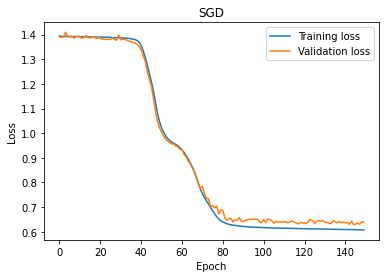

In [50]:
import matplotlib.pyplot as plt

%matplotlib inline


plt.plot(range(num_epoch), train_losses, valid_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(["Training loss", "Validation loss"])
plt.title('SGD')
plt.show()

## 2. Word Vector (70 points)

In this section, you are required to implement a Word2Vec model.

### 2.1 Written Questions (25 points, each question is 5 points. )


To better understand the insight of Word2Vec, Please answer the following questions. (You can either answer those questions in this notebook, or submit a pdf with your answers.)

1. Derive the gradients of the sigmoid function and show that it can be rewritten as a function of the function value (i.e., in some expressions where only $\sigma(x)$, but not $x$, is present). Assume that the input $x$ is a scalar for this question. Recall, the sigmoid function is:

$$\sigma(x) = \frac{1}{1+e^{-x}}$$


2. Assume you are given a predicted word vector $\mathbf{v}_c$ corresponding to the center word $c$ for skipgram, and the word prediction is made with the **softmax** function，

<center>$\hat{y}_o = p(o|c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{\sum_{w=1}^W \exp(\mathbf{u}_w^\top\mathbf{v}_c)}$</center>

> where $o$ is the expected word, $w$ denotes the $w$-th word and $\mathbf{u}_w$ (w = 1, ..., W) are the “output” word vectors for all words in the vocabulary.
The cross entropy function is defined as:

<center>$J_\text{CE}(o,\mathbf{v}_c, U) =CE(\mathbf{y}, \hat{\mathbf{y}})= -\sum_i y_i \log(\hat{y}_i)$</center>

> where the gold vector $\mathbf{y}$ is a one-hot vector, the softmax prediction vector $\hat{\mathbf{y}}$ is a
probability distribution over the output space, and $U= [u_1, u_2, ..., u_W]$ is the matrix of all the output vectors. 
Assume cross entropy cost is applied to this prediction, derive the gradients with respect to $\mathbf{v}_c$.

3. Derive gradients for the "output" word vector $\mathbf{u}_w$ (including $\mathbf{u}_o$) in the previous part.


4. Repeat (2) and (3) assuming we are using the negative sampling loss for the predicted vector $\mathbf{v}_c$. Assume that K negative samples (words) are drawn and they are 1,...,K respectively. For simplicity of notation, assume ($o\notin \{1,...,K\}$). Again for a given word $o$, use $\mathbf{u}_o$ to denote its output vector. The negative sampling loss function in this case is:
$$J_\text{neg-sample}(o,\mathbf{v}_c, U) =-\log(\sigma(\mathbf{u}_o^\top \mathbf{v}_c)) -\sum_{k=1}^K \log(\sigma(-\mathbf{u}_k^\top \mathbf{v}_c))$$

5. Derive gradients for all of the word vectors for skip-gram given the previous parts and given a set of context words $[\text{word}_{c-m}, . . . , \text{word}_c, . . . , \text{word}_{c+m}]$ where $m$ is the
context size. Denote the "input" and "output" word vectors for word $k$ as $\mathbf{v}_k$ and $\mathbf{u}_k$ respectively.

> _Hint: feel free to use $F(o, \mathbf{v}_c)$ (where $o$ is the expected word) as a placeholder for the $J_\text{CE}(o,\mathbf{v}_c ...)$ or $J_\text{neg-sample}(o,\mathbf{v}_c...)$ cost functions in this part -- you’ll see that this is a useful abstraction for the coding part. That is, your solution may contain terms of the form $\frac{\partial F(o, \mathbf{v}_c)}{\partial ...}$ Recall that for skip-gram, the cost for a context centered around c is:
$$\sum_{-m \leq j\leq m, j\neq0} F(w_{c+j}, \mathbf{v}_c)$$_

### 2.2 Coding (45 points)

#### 2.2.1 Sigmoid Function (Fill the code: 5 points)

In [84]:
def sigmoid(x):
    ''' Compute the sigmoid function.
        Inputs:
            x: A scalar or numpy array
        Outputs:
            s: sigmoid(x)
    '''
    s = 0.
    
    ### Start your code
    
    s = 1 / (1 + np.exp(-x))
    # s = np.where(x >= 0, 1/(1 + np.exp(-x)), np.exp(x)/(1 + np.exp(x))) # To prevent overflow this implementation might be better. Please uncomment if errors are seen while testing. Source: https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    
    ### End
    
    return s


def softmax(x):
    ''' Compute the softmax function for each row of the input x. 
        It is crucial that this function is optimized for speed 
        because it will be used frequently in later code. 

        Inputs:
        x: A D dimensional vector or N x D dimensional numpy matrix.
        Outputs:
        x: You are allowed to modify x in-place
    '''
    if len(x.shape) == 1:
        x = x - np.max(x)
        return np.exp(x) / np.sum(np.exp(x))
    else:
        x = x - np.max(x, axis=1).reshape(-1, 1)
    return np.exp(x) / np.sum(np.exp(x), axis=1).reshape(-1, 1)
    

#### 2.2.2 Word2Vec models with Stochastic gradient descent (SGD)

#### Naive Softmax loss & gradient function for word2vec models (fill the code: 10 points)

In [85]:
def naiveSoftmaxLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset):
    ''' Implement tha naive softmax loss and gradients between a center word's embedding 
        and an outside word's embedding. This will be the building block for our word2vec
        models.
        
        Inputs:
            centerWordVec: numpy ndarray, center word's embedding (v_c in question 2.1.1).
            outsideWordIdx: integer, the index of the outside word (o of u_o in question 2.1.1).
            outsideVectors: outside vectors (rows of matrix) for all words in vocab (U in question 2.1.1).
            dataset: for negative sampling, ignore this argument in this function.
        
        Outputs:
            loss: naive softmax loss
            gradCenterVec: the gradient with respect to the center word vector (dJ/dv_c in question 2.1.1).
            gradOutsideVecs: the gradient with respect to all the outside word vectors (dJ / dU).
    '''
    
    ### Start your code (Please use the provided softmax function)
    
    y_hat = softmax(outsideVectors@centerWordVec)
    loss = -np.log(y_hat[outsideWordIdx])
    y_hat[outsideWordIdx] -= 1.0
    gradCenterVec = outsideVectors.T@y_hat
    gradOutsideVecs = np.outer(y_hat,centerWordVec)
    
    ### End
    
    return loss, gradCenterVec, gradOutsideVecs

#### Negative sampling loss function for word2vec models (Fill the code: 10 points)

In [86]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

def negSamplingLossAndGradient(centerWordVec, outsideWordIdx, outsideVectors, dataset, K=10):
    ''' Implement the negative sampling loss and gradients for a centerWordVec
        and a outsideWordIdx word vector as a building block for word2vec
        models. K is the number of negative samples to take.

        Note: The same word may be negatively sampled multiple times. For
        example if an outside word is sampled twice, you shall have to
        double count the gradient with respect to this word. Thrice if
        it was sampled three times, and so forth.

        Inputs/Outpus Specifications: same as naiveSoftmaxLossAndGradient
    '''
    
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices
    
    ### Start your code (Please use your implementation of sigmoid)
    
    gradCenterVec, gradOutsideVecs = np.zeros(centerWordVec.shape),np.zeros(outsideVectors.shape)
    
    y_hat = sigmoid(np.dot(outsideVectors[outsideWordIdx],centerWordVec))
    loss = -np.log(y_hat)
    gradCenterVec += outsideVectors[outsideWordIdx] * (y_hat - 1.0)
    gradOutsideVecs[outsideWordIdx] = centerWordVec * (y_hat - 1.0)
    
    for i in range(K):
        y_hat = sigmoid(-np.dot(outsideVectors[indices[i+1]],centerWordVec))
        loss -= np.log(y_hat)
        gradCenterVec += outsideVectors[indices[i+1]] * (1.0 - y_hat)
        gradOutsideVecs[indices[i+1]] += centerWordVec * (1.0 - y_hat)
    
    ### End
    
    return loss, gradCenterVec, gradOutsideVecs


#### Skip-gram model in word2vec (Fill the code, 10 points)

In [87]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    ''' Implement the skip-gram model in this function.
    
        Inputs:
            currentCenterWord: a string of the current center word
            windowSize: integer, context window size
            outsideWords: list of no more than 2*windowSize strings, the outside words
            word2Ind: a dictionary that maps words to their indices in
                      the word vector list
            centerWordVectors: center word vectors (as rows) for all words in vocab
                                (V in pdf handout)
            outsideVectors: outside word vectors (as rows) for all words in vocab
                            (U in pdf handout)
            word2vecLossAndGradient: the loss and gradient function for
                                       a prediction vector given the outsideWordIdx
                                       word vectors, could be one of the two
                                       loss functions you implemented above.

        Outputs:
            loss: the loss function value for the skip-gram model
                    (J in the pdf handout)
            gradCenterVecs: the gradient with respect to the center word vectors
                    (dJ / dV in the pdf handout)
            gradOutsideVectors: the gradient with respect to the outside word vectors
                                (dJ / dU in the pdf handout)
    '''
    
    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    # Start your code
    
    i = word2Ind[currentCenterWord]
    centerWordVec = centerWordVectors[i]
    
    for ow in outsideWords:
        j = word2Ind[ow]
        ls, cnt_grad, out_grad = word2vecLossAndGradient(centerWordVec, j, outsideVectors, dataset)
        loss += ls
        gradCenterVecs[i] += cnt_grad
        gradOutsideVectors += out_grad


    # End

    return loss, gradCenterVecs, gradOutsideVectors



def normalizeRows(x):
    """ Row normalization function

    Implement a function that normalizes each row of a matrix to have
    unit length.
    """
    N = x.shape[0]
    x /= np.sqrt(np.sum(x**2, axis=1)).reshape((N, 1)) + 1e-30
    return x


def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset,
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2), :]
    outsideVectors = wordVectors[int(N/2):, :]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad

#### Run the following cell to test your implementations

In [88]:
#############################################
# Testing functions below. DO NOT MODIFY!   #
############################################

import random
import numpy as np

from utils.gradcheck import gradcheck_naive


def test_word2vec():
    """ Test the two word2vec implementations, before running on Stanford Sentiment Treebank """
    dataset = type('dummy', (), {})()

    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0, 4)], \
            [tokens[random.randint(0, 4)] for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10, 3))
    dummy_tokens = dict([("a", 0), ("b", 1), ("c", 2), ("d", 3), ("e", 4)])

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")

    print("\n=== Results ===")
    print("Skip-Gram with naiveSoftmaxLossAndGradient")

    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                  dummy_tokens, dummy_vectors[:5, :], dummy_vectors[5:, :], dataset)
    )
    )

    print("Expected Result: Value should approximate these:")
    print("""Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]
    """)

    print("Skip-Gram with negSamplingLossAndGradient")
    print("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\n Gradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5, :],
                  dummy_vectors[5:, :], dataset, negSamplingLossAndGradient)
    )
    )
    print("Expected Result: Value should approximate these:")
    print("""Loss: 16.15119285363322
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-4.54650789 -1.85942252  0.76397441]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
 Gradient wrt Outside Vectors (dJ/dU):
 [[-0.69148188  0.31730185  2.41364029]
 [-0.22716495  0.10423969  0.79292674]
 [-0.45528438  0.20891737  1.58918512]
 [-0.31602611  0.14501561  1.10309954]
 [-0.80620296  0.36994417  2.81407799]]
    """)
    
test_word2vec()

==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====
Gradient check passed!
==== Gradient check for skip-gram with negSamplingLossAndGradient ====
Gradient check passed!

=== Results ===
Skip-Gram with naiveSoftmaxLossAndGradient
Your Result:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]

Expected Result: Value should approximate these:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0

#### 2.2.3 K-nearest neighbors. (Fill the code: 10 points)

In [133]:
def cosine_similartiy(v1, v2):
    ''' return the cosine similarity of two vectors
        
        Inputs:
            v1: a numpy ndarray
            v2: a numpy ndarray
        Outputs:
            s: the cosine similarity of v1 and v2
    '''
    
    ### Start your code
    
    s = np.dot(v1,v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    
    ### End
    
    return s

def knn(vec, mat, k):
    ''' Implement the KNN algorithm, which will be used for analysis.
        
        Inputs:
            vec: numpy ndarray, the target vector
            mat: numpy ndarray, a matrix contains all the vectors (each row is a vector)
            k: the number of the nearest neighbors you want to find.
            
        Outputs:
            indices: the k indices of the matrix's rows that are closest to the vec
    '''
                          
    ### Start your code
    
    scores = np.array([cosine_similartiy(vec, v2) for v2 in mat])
    indices = (-scores).argsort()[:k]
    
    ### End
    
    return indices

#### 2.2.4 Evalution the model with visualization and knn

#### Run the following cell to train the word2vec model

_Note: The training process may take a long time depending on the efficiency of your implementation. Plan accordingly!_

In [116]:
import os.path as op
import numpy as np
import random
import glob
import pickle

import time
from utils.treebank import StanfordSentiment

SAVE_PARAMS_EVERY = 5000


def load_saved_params():
    """
    A helper function that loads previously saved parameters and resets
    iteration start.
    """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter

    if st > 0:
        params_file = "saved_params_%d.npy" % st
        state_file = "saved_state_%d.pickle" % st
        params = np.load(params_file)
        with open(state_file, "rb") as f:
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None


def save_params(iter, params):
    params_file = "saved_params_%d.npy" % iter
    np.save(params_file, params)
    with open("saved_state_%d.pickle" % iter, "wb") as f:
        pickle.dump(random.getstate(), f)


def sgd(f, x0, step, iterations, postprocessing=None, useSaved=False,
        PRINT_EVERY=1000):
    """ Stochastic Gradient Descent

    Implement the stochastic gradient descent method in this function.

    Arguments:
    f -- the function to optimize, it should take a single
         argument and yield two outputs, a loss and the gradient
         with respect to the arguments
    x0 -- the initial point to start SGD from
    step -- the step size for SGD
    iterations -- total iterations to run SGD for
    postprocessing -- postprocessing function for the parameters
                      if necessary. In the case of word2vec we will need to
                      normalize the word vectors to have unit length.
    PRINT_EVERY -- specifies how many iterations to output loss

    Return:
    x -- the parameter value after SGD finishes
    """
    print('sgd')

    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000

    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)

        if state:
            random.setstate(state)
    else:
        start_iter = 0

    x = x0

    if not postprocessing:
        def postprocessing(x): return x

    exploss = None

    last_time = time.time()
    for iter in range(start_iter + 1, iterations + 1):
        # You might want to print the progress every few iterations.

        loss = None
        loss, g = f(x)
        x -= step * g

        x = postprocessing(x)
        if iter % PRINT_EVERY == 0:
            if not exploss:
                exploss = loss
            else:
                exploss = .95 * exploss + .05 * loss
            print("iter %d: %f, duration %d" % (iter, exploss, int(time.time() - last_time)))
            last_time = time.time()

        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)

        if iter % ANNEAL_EVERY == 0:
            step *= 0.5

    return x

In [117]:
import time
from utils.treebank import StanfordSentiment

random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)


# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)

startTime = time.time()
wordVectors = np.concatenate(
    ((np.random.rand(nWords, dimVectors) - 0.5) /
     dimVectors, np.zeros((nWords, dimVectors))),
    axis=0)

wordVectors = sgd(
    lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C,
                                     negSamplingLossAndGradient),
    wordVectors, 0.3, 40000, None, True, PRINT_EVERY=100)

print("sanity check: cost at convergence should be around or below 10")
print("training took %d seconds" % (time.time() - startTime))

tokenizing:   0%|          | 0/10000 [00:00<?, ?it/s]

sgd
iter 100: 26.838811, duration 23
iter 200: 26.922662, duration 16
iter 300: 26.674469, duration 16
iter 400: 26.560700, duration 16
iter 500: 26.406836, duration 16
iter 600: 26.298790, duration 16
iter 700: 26.432520, duration 16
iter 800: 26.277451, duration 16
iter 900: 26.214011, duration 16
iter 1000: 26.191856, duration 16
iter 1100: 26.125123, duration 13
iter 1200: 26.183635, duration 11
iter 1300: 25.964566, duration 12
iter 1400: 26.130126, duration 12
iter 1500: 26.119661, duration 12
iter 1600: 25.865689, duration 12
iter 1700: 25.677752, duration 12
iter 1800: 25.476244, duration 13
iter 1900: 25.589445, duration 14
iter 2000: 25.506106, duration 13
iter 2100: 25.472869, duration 13
iter 2200: 25.340392, duration 14
iter 2300: 25.246540, duration 14
iter 2400: 25.194112, duration 14
iter 2500: 25.249451, duration 13
iter 2600: 25.294640, duration 14
iter 2700: 25.310057, duration 14
iter 2800: 25.257413, duration 14
iter 2900: 25.205463, duration 15
iter 3000: 25.14582

iter 23900: 11.552318, duration 14
iter 24000: 11.557196, duration 14
iter 24100: 11.544947, duration 14
iter 24200: 11.571553, duration 14
iter 24300: 11.485304, duration 14
iter 24400: 11.498506, duration 15
iter 24500: 11.437380, duration 15
iter 24600: 11.409179, duration 14
iter 24700: 11.383600, duration 14
iter 24800: 11.489163, duration 14
iter 24900: 11.443744, duration 14
iter 25000: 11.425755, duration 14
iter 25100: 11.436167, duration 14
iter 25200: 11.505710, duration 14
iter 25300: 11.514796, duration 14
iter 25400: 11.518827, duration 14
iter 25500: 11.395884, duration 14
iter 25600: 11.406640, duration 14
iter 25700: 11.413527, duration 14
iter 25800: 11.378377, duration 14
iter 25900: 11.416076, duration 14
iter 26000: 11.406413, duration 14
iter 26100: 11.444229, duration 14
iter 26200: 11.382147, duration 14
iter 26300: 11.397759, duration 14
iter 26400: 11.378495, duration 14
iter 26500: 11.356597, duration 14
iter 26600: 11.403630, duration 14
iter 26700: 11.38998

#### Run the following cell to obtain the visulaization of words

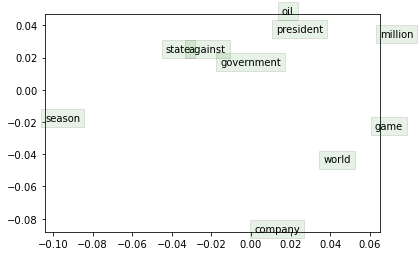

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

# concatenate the input and output word vectors
wordVectors = np.concatenate(
    (wordVectors[:nWords, :], wordVectors[nWords:, :]),
    axis=0)

visualizeWords = [
    'state', 'season', 'company', 'world', 'against', 
    'president', 'game', 'million', 'oil', 'government'
]

visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U, S, V = np.linalg.svd(covariance)
coord = temp.dot(U[:, 0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i, 0], coord[i, 1], visualizeWords[i],
             bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:, 0]), np.max(coord[:, 0])))
plt.ylim((np.min(coord[:, 1]), np.max(coord[:, 1])))

plt.savefig('word_vectors.png')
plt.show()

#### Run the following cell to obtain the k-nearest neighbors

In [134]:
centerVectors = wordVectors[:nWords, :]
outputVectors = wordVectors[nWords:, :]
for word in visualizeWords:
    idx = tokens[word]
    vec = outputVectors[idx]
    indices = knn(vec, outputVectors, 10)
    closed_words = [list(tokens.keys())[i] for i in indices]
    print('Word: "{}" is close to {}'.format(word, closed_words))

Word: "state" is close to ['state', 'druyun', 'nashiri', 'astronomy', 'texting', 'supplier', 'electric', 'lawsuit', 'bath', 'blizzard']
Word: "season" is close to ['season', 'berlusconi', 'pam', 'padraig', 'won', 'shiite', 'ak', 'bb', 'peoplesoft', 'straight']
Word: "company" is close to ['company', 'says', 'trophy', 'ship', 'global', 'media', 'chicago', 'battles', 'contravened', 'ago']
Word: "world" is close to ['world', 'lake', 'indication', 'meetings', 'baghdad', 'power', 'sbux', 'outages', 'purefoy', 'nikkei']
Word: "against" is close to ['against', 'shepherd', 'cable', 'crushing', 'squeeze', 'prayers', 'perhaps', 'rocks', 'shelling', 'azeri']
Word: "president" is close to ['president', 'uniteds', 'purnomo', 'marek', 'zedong', 'freshly', 'delegation', 'especially', 'orwell', 'destabilize']
Word: "game" is close to ['game', 'bench', 'such', 'albanians', 'proper', 'three', 'next', 'failed', 'craft', 'eagles']
Word: "million" is close to ['million', 'explodes', 'technological', 'versa

Analysis/Observation:
It seems that words are starting to cluster in the vector space. Interestingly similar topics or words that are tend to be used often or have some semantic meaning are starting to group in these clusters. In my personal opinion, this might introduce some bias if vocab size is not sufficiently large since certain words for example the name Safwan and the word Oil are scored close which would not be the case if vocab size was larger. This also highlights biases in the source media since media of certain region may only refer to words, names, places, etc. in specific limited instances.